In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

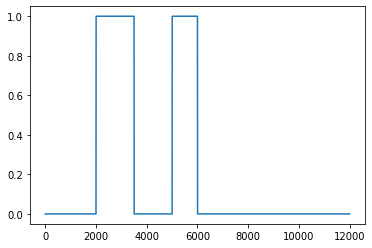

In [2]:
#Exercise 4.
#Task 1.
#Subtask a)

#1. Generate a signal
signal = np.zeros(12000)
signal[2000:3500] = 1.0
signal[5000:6000] = 1.0
plt.plot(signal)

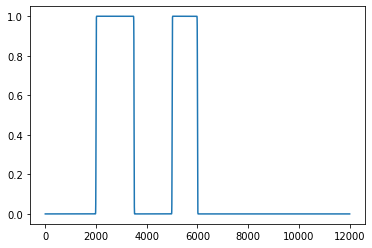

In [3]:
#2. Apply gaussian filter

def nth_gradient(X, n = 0):
    """
    N-th numerical differention
    """
    grad = X
    if n > 0:
        for i in range(n):
            dx = np.abs(X[1] - X[0])
            grad = np.gradient(X, dx)
    return grad

def get_kernel(sz, mu=0.0, sigma=0.05, sum_one=False, derivative = 0):
    """
    Differentable kernel θ  with integral == 1
    """
    #2.1 Construct kernel
    kernel = np.linspace(-1,1,sz)
    kernel = np.exp(-(((kernel-mu)**2.0)/(2.0*sigma**2)))
    
    if derivative >= 1:
        kernel = nth_gradient(kernel, derivative)
    
    #2.2 If integral == 1 is required
    if sum_one:
        kernel = kernel/sum(kernel)
        
    return kernel
        
def gaussian_smoothening(signal, mu=0.0, sigma=0.05, sum_one=False, derivative = 0):
    """
    Guassian smoothing function
    """
    #2.1 FFT
    signal_transformed = np.fft.fft(signal)
    signal_amplitude = np.abs(signal_transformed),
    signal_angle = np.angle(signal_transformed)
    signal_phase = np.exp(1j*signal_angle)
    signal_amplitude = np.fft.fftshift(signal_amplitude)

    #2.2 Construct kernel
    kernel = get_kernel(len(signal), mu=mu, sigma=sigma, sum_one=sum_one, derivative = derivative)

    #2.3 Apply kernel and reconstruct signal
    signal_amplitude = (kernel*signal_amplitude)[0]
    signal_amplitude = np.fft.ifftshift(signal_amplitude)
    signal_filtered = np.real(np.fft.ifft(signal_amplitude*signal_phase))
    return signal_filtered
signal_filtered = gaussian_smoothening(signal, 0.0, 0.05, False, 0)
plt.plot(signal_filtered)

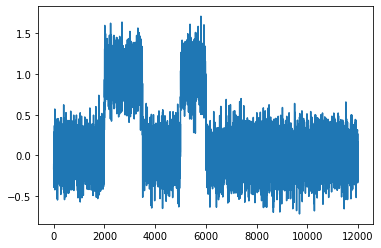

In [4]:
#3. Add noise
noise = np.random.normal(0.0,0.2,len(signal_filtered))
signal_filtered_noisy = signal_filtered+noise
plt.plot(signal_filtered_noisy)

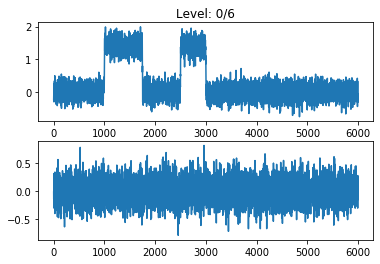

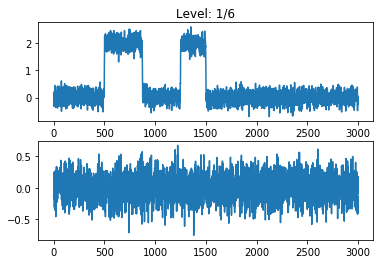

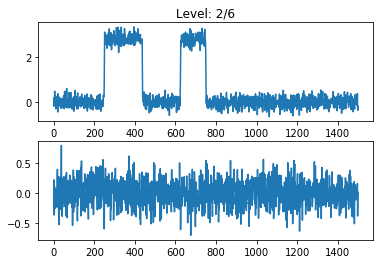

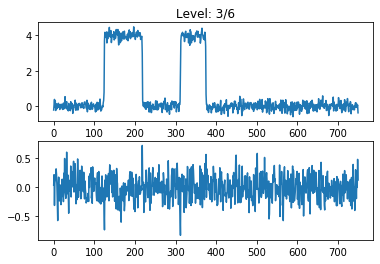

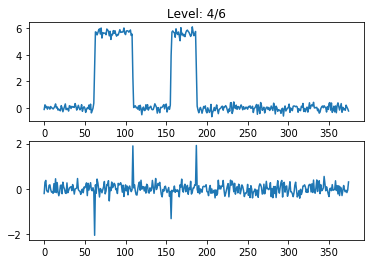

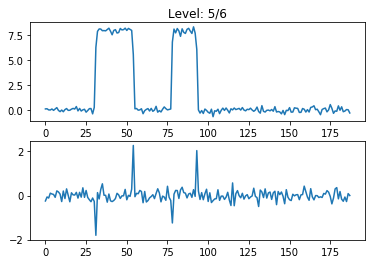

In [5]:
# b)
level = 6
mode = 'haar'

#Source: 
#https://github.com/PyWavelets/pywt/releases
#pywt/_multilevel.py wavedec
cA_list = [] #rename = []
cD_list = []
cA = signal_filtered_noisy
for i in range(level):
    cA, cD = pywt.dwt(cA, mode) #rename a,d
    cD_list.append(cD)
    cA_list.append(cA)

for i in range(level):
    plt.subplot(2,1,1)
    plt.plot(cA_list[i])
    plt.title("Level: {0}/{1}".format(i,level))
    plt.subplot(2,1,2)
    plt.plot(cD_list[i])
    plt.show()
    
#The noise is reduced with increasing levels, visually closest result to original signal at level 3 or 4.

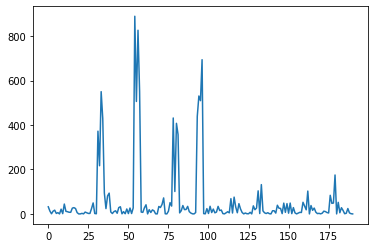

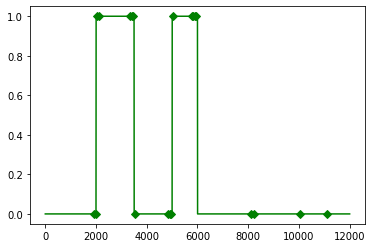

In [14]:
def normalize(X):
    return X/X.std()
        
def scale_product(X, scale, mu, sigma):
    kernel = get_kernel(4, mu, sigma, True, 0)
    w_j = nth_gradient(np.convolve(X, kernel), scale)
    w_jpp = nth_gradient(np.convolve(X, kernel), scale+1)
    return np.abs((w_j*2**scale)*(w_jpp*2**(scale+1)))

coeffictients=5
scale=2
sigma = 0.3
mu = 0.0
X_0 = normalize(cD_list[coeffictients])
Y_0 = scale_product(X_0, scale, mu, sigma)
t = Y_0.std()*np.linalg.norm(get_kernel(4, mu, sigma, True, 0))

plt.plot(Y_0)
plt.show()

upscale_factor = int(len(signal)/len(Y_0))
markers_on = list([int(upscale_factor*x) for x in (np.where(Y_0>t)[0])])
plt.plot(signal, '-gD', markevery=markers_on)
plt.show()